# Project Part 2

In [160]:
import pandas as pd
import numpy as np

x = 'Text'
y = 'IsToxic'
df = pd.read_csv("youtoxic_english_1000.csv")
print(f"df.shape: {df.shape}")
df[[x,y]].head(10)

df.shape: (1000, 15)


,Text,IsToxic
0,If only people would just take a step back and...,False
1,Law enforcement is not trained to shoot to app...,True
2,\nDont you reckon them 'black lives matter' ba...,True
3,There are a very large number of people who do...,False
4,"The Arab dude is absolutely right, he should h...",False
5,here people his facebook is https://www.facebo...,True
6,"Check out this you tube post. ""Black man goes ...",True
7,I would LOVE to see this pussy go to Staten Is...,True
8,I agree with the protestor.,False
9,mike browns father was made to say that boooshit,True


In [163]:
df.IsToxic.value_counts(normalize=True)

False    0.538
True     0.462
Name: IsToxic, dtype: float64

### Data Cleaning

In [122]:
from textblob import TextBlob, Word, Blobber
from nltk.stem import PorterStemmer
#import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords

# Converting data set to String type
df['Text'] = df['Text'].astype(str)
df = df[~df["Text"].isnull()]

# Special character cleaning
def clean(txt):
    txt = txt.str.replace("()", "")
    txt = txt.str.replace('(<a).*(>).*()', '')
    txt = txt.str.replace('(&amp)', '')
    txt = txt.str.replace('(&gt)', '')
    txt = txt.str.replace('(&lt)', '')
    txt = txt.str.replace('(\xa0)', ' ')  
    return txtdf['Text'] == clean(df['Text'])

# Converting to lower case
df['cleanText'] = df['Text'].apply(lambda x: " ".join(x.lower() for x in x.split()))

# Removing Stopwords

stop = stopwords.words('english')
df['cleanText'] = df['cleanText'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

# Correcting any spelling mistake in the dataset
df['cleanText'].apply(lambda x: str(TextBlob(x).correct()))

# Stemming words in the dataset
st = PorterStemmer()
df['cleanText'] = df['cleanText'].apply(lambda x: " ".join([st.stem(word) for word in x.split()]))

# Removing punctiation
df['cleanText'] = df['cleanText'].str.replace('[^\w\s]', '')

df[['cleanText', 'IsToxic']].head(10)

/var/folders/zc/w3_gp3bj2r75g6hkvhz1zd4w0000gn/T/ipykernel_1596/1270096598.py:37: FutureWarning: The default value of regex will change from True to False in a future version.
  df['cleanText'] = df['cleanText'].str.replace('[^\w\s]', '')


,cleanText,IsToxic
0,peopl would take step back make case them anyo...,False
1,law enforc train shoot apprehend train shoot k...,True
2,dont reckon black live matter banner held whit...,True
3,larg number peopl like polic officers call cri...,False
4,arab dude absolut right shot 6 extra time shoo...,False
5,peopl facebook httpswwwfacebookcombassemmasri5...,True
6,check tube post black man goe epic rant fergus...,True
7,would love see pussi go staten island spit cop...,True
8,agre protestor,False
9,mike brown father made say boooshit,True


### Split data into train and validations sets.

In [139]:
from sklearn.model_selection import train_test_split

cleanText = df['cleanText'].copy()
isToxic = df['IsToxic'].copy()

text_train, text_remaining, is_toxic_train, is_toxic_remaining = train_test_split(cleanText, isToxic, train_size=0.8)

text_val, text_test, is_toxic_val, is_toxic_test = train_test_split(text_remaining,is_toxic_remaining,test_size=0.5)

print(text_train.shape),print(is_toxic_train.shape)
print(text_val.shape),print(is_toxic_val.shape)
print(text_test.shape),print(is_toxic_test.shape)

(800,)
(800,)
(100,)
(100,)
(100,)
(100,)


(None, None)

#### Vectorization of Data

In [140]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer()

text_train = tfidf_vectorizer.fit_transform(text_train).toarray()
print(f"text_train.shape = { text_train.shape}")

text_train.shape = (800, 3621)


#### Decision Tree

In [141]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=50)
model = model.fit(text_train, is_toxic_train)

predictions_train = model.predict(text_train)

#### Display

accuracy (on X_train): 1.0000


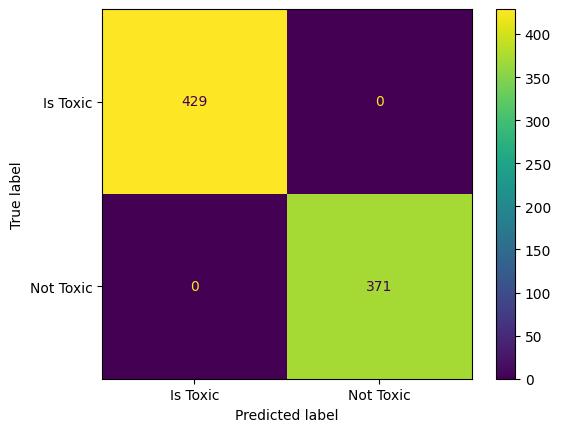

In [142]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

display = ConfusionMatrixDisplay(confusion_matrix(is_toxic_train, predictions_train),
display_labels=['Is Toxic', 'Not Toxic'])
display.plot()
print(f"accuracy (on X_train): {accuracy_score(is_toxic_train,predictions_train):.4f}")

add scores here

In [143]:
text_val = tfidf_vectorizer.transform(text_val).toarray()
print(f"text_val.shape = {text_val.shape}")

text_val.shape = (100, 3621)


accuracy (on X_train): 0.7300


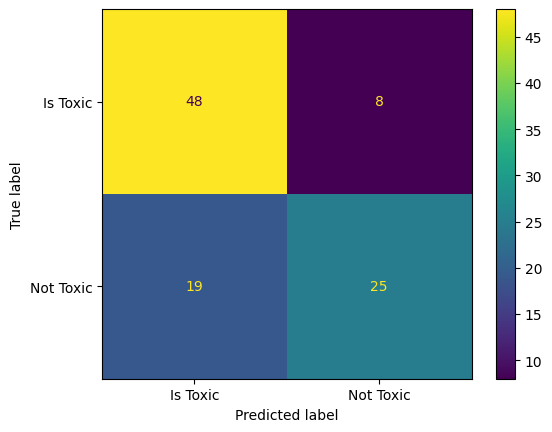

In [144]:
predictions_val = model.predict(text_val)
disp = ConfusionMatrixDisplay(confusion_matrix(is_toxic_val, predictions_val), display_labels=['Is Toxic', 'Not Toxic'])
disp.plot()
print(f"accuracy (on X_train): {accuracy_score(is_toxic_val, predictions_val):.4f}")

In [145]:
from sklearn.metrics import log_loss

def tuneModel(hp_value):
    rf_model = RandomForestClassifier(n_estimators=hp_value)
    rf_model.fit(text_train, is_toxic_train)
    is_toxic_train_pred_prob = rf_model.predict_proba(text_train)
    is_toxic_train_pred = rf_model.predict(text_train)
    is_toxic_val_pred_prob = rf_model.predict_proba(text_val)
    is_toxic_val_pred = rf_model.predict(text_val)
    train_loss = log_loss(is_toxic_train, is_toxic_train_pred_prob,labels=['Is Toxic', 'Not Toxic'])
    train_acc = accuracy_score(is_toxic_train,is_toxic_train_pred)
    val_loss = log_loss(is_toxic_val,is_toxic_val_pred_prob,labels=['Is Toxic', 'Not Toxic'])
    val_acc = accuracy_score(is_toxic_val, is_toxic_val_pred)
    return (train_loss, val_loss, train_acc, val_acc)



In [146]:
import matplotlib.pyplot as plt

def loss_and_accuracy_plot(metrics, hyp_param_vals):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

    ax1.set_xticks(hyp_param_vals)
    ax1.set(xlabel="n_estimators", ylabel="loss (lower is better)")
    ax1.plot(hyp_param_vals, [metric[1] for metric in metrics], '--ro') # validation loss
    ax1.plot(hyp_param_vals, [metric[0] for metric in metrics], '--bo') # training loss
    ax1.legend(["Validation Loss", "Train Loss"], loc=1)

    ax2.set_xticks(hyp_param_vals)
    ax2.set(xlabel="n_estimators", ylabel="accuracy (higher is better)")
    ax2.plot(hyp_param_vals, [metric[3] for metric in metrics], '--ro') # validation accuracy
    ax2.plot(hyp_param_vals, [metric[2] for metric in metrics], '--bo') # training accuracy
    ax2.legend(["Validation Accuracy", "Train Accuracy"], loc=4)

/Users/marcomeraz/Library/Python/3.9/lib/python/site-packages/numpy/lib/arraysetops.py:612: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)
/Users/marcomeraz/Library/Python/3.9/lib/python/site-packages/numpy/lib/arraysetops.py:612: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)
/Users/marcomeraz/Library/Python/3.9/lib/python/site-packages/numpy/lib/arraysetops.py:612: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)
/Users/marcomeraz/Library/Python/3.9/lib/python/site-packages/numpy/lib/arraysetops.py:612: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)
/Users/marcomeraz/Library/Python/3.9/lib/pyt

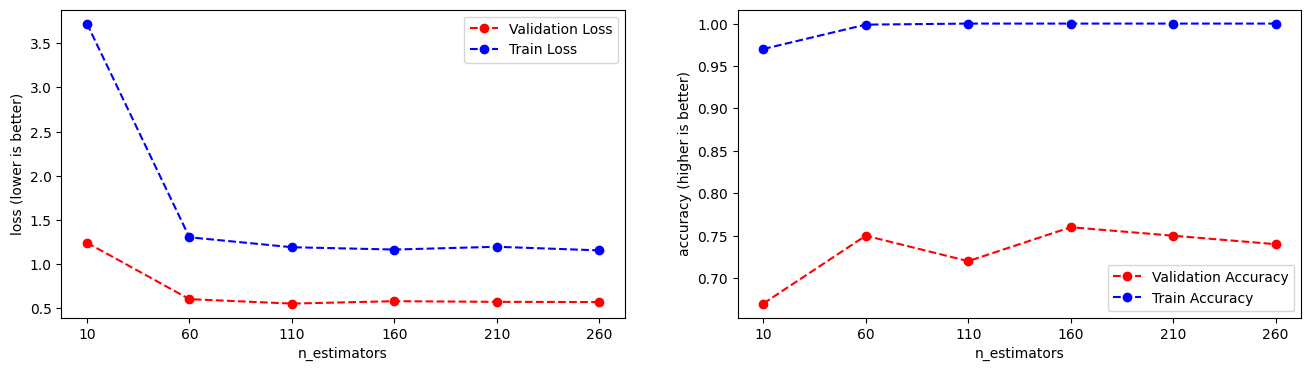

In [147]:
# n_estimators
estim_hyp_param_values = list(range(10,261,50))
# min_samples_split 
split_hyp_param_values = [2,3] +list(range(5,50,10))

metrics = []
for hp in estim_hyp_param_values:
    metrics.append(tuneModel(hp))

loss_and_accuracy_plot(metrics, estim_hyp_param_values)


In [148]:
# a simple matrix with first row containing hyperparam values, second row containing validation loss, third row containing validation accuracy
# (this could be presented in an even nicer format using a pandas dataframe if you like)

tuning_results = np.array([estim_hyp_param_values, [round(metric[1],2) for metric in metrics], [round(metric[3],2) for metric in metrics]])
print(tuning_results)

[[ 10.    60.   110.   160.   210.   260.  ]
 [  1.24   0.6    0.55   0.58   0.57   0.57]
 [  0.67   0.75   0.72   0.76   0.75   0.74]]


In [150]:
text_test = tfidf_vectorizer.transform(text_test).toarray()

In [158]:
# refit the model with the best hyperparameter value you found
model = RandomForestClassifier(n_estimators=160)
model = model.fit(text_train, is_toxic_train)

# this make predictions for the test set
predictions_test = model.predict(text_test)
print(f"accuracy (on text_test): {accuracy_score(is_toxic_test,predictions_test):.4f}")

accuracy (on text_test): 0.7400


accuracy (on text_test): 0.7300


accuracy (on text_test): 0.7400


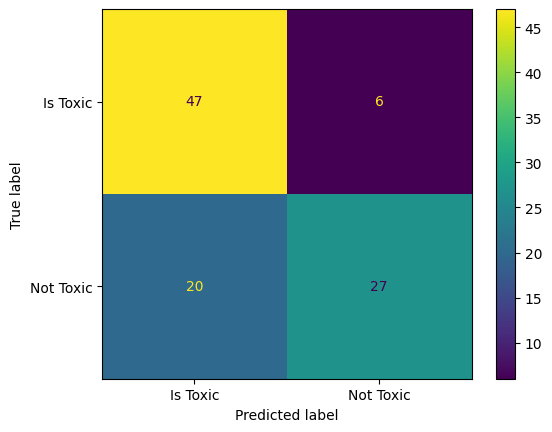

In [159]:
disp = ConfusionMatrixDisplay(confusion_matrix(is_toxic_test, predictions_test), display_labels=['Is Toxic', 'Not Toxic'])
disp.plot()

print(f"accuracy (on text_test): {accuracy_score(is_toxic_test,predictions_test):.4f}")